In [1]:
import sys
# sys.path.insert(0, '../ATE_Simulations/Results')
sys.path.insert(0, '../../src')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from utils.visualization_utils import perc, SetPlotRC, ApplyFont

import warnings
warnings.filterwarnings("ignore")

In [2]:
if not os.path.exists("AblationFigures"):
    os.mkdir("AblationFigures")

# JobCorps Dataset Comparison

In [3]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(30, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.000,"[[48.86473364192898], [48.990869545609215], [4...","[0.6749048186307575, 0.6750466169656796, 0.675..."
1,Kernel_Alternative_Proxy,2913,0.0,0.004,"[[73.31771213954441], [73.46805648865497], [73...","[1.3847744138229336, 1.391473623539369, 1.3984..."
2,Kernel_Alternative_Proxy,2913,3.0,0.000,"[[38.793866479894085], [38.91635828978584], [3...","[0.7347035200421876, 0.7353425346802407, 0.735..."
3,Kernel_Alternative_Proxy,2913,3.0,0.004,"[[61.72227312746135], [61.8430103599163], [61....","[0.9563242812992885, 0.9578529362452997, 0.959..."
4,Kernel_Negative_Control,2913,-1.0,-1.000,"[[53.8735806188698], [53.94011681681212], [54....","[1.565362876988125, 1.5607518362152548, 1.5561..."


In [4]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,2.556814,0.6828927
1,Kernel Negative Control,2.1078548,0.56762016
2,Kernel Proxy Variable,2.4360714,1.164227


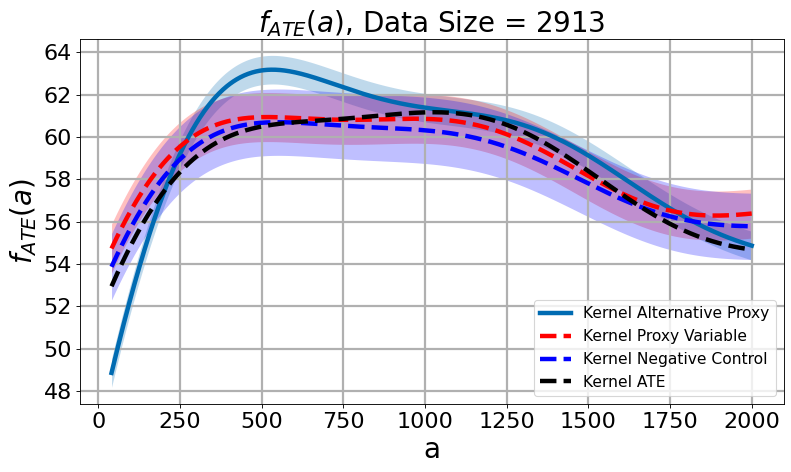

In [5]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    # plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 1.1 (Incomplete Z)

In [6]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting1.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[48.821639064446344], [48.9436831736427], [49...","[0.7900399968899035, 0.7873464928397841, 0.784..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[57.34893033453541], [57.407527168437355], [5...","[1.3596400985684676, 1.3539455268062197, 1.348..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[60.33055874468016], [60.3786145016184], [60....","[2.318970248926915, 2.298993283165293, 2.27910..."


In [7]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,2.1818428,0.3392408
1,Kernel Negative Control,4.589626,1.4137241
2,Kernel Proxy Variable,12.922729,4.566697


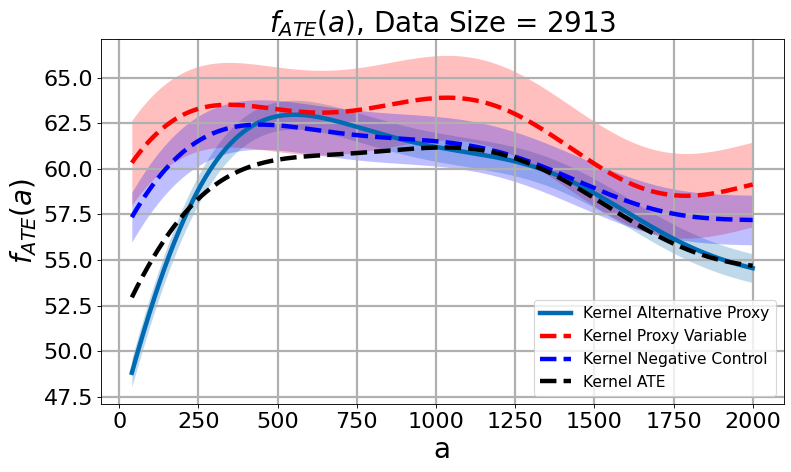

In [8]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting1.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 1.2 (Incomplete W)

In [9]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting1.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[53.47054796879563], [53.57566609601567], [53...","[1.1350648140136257, 1.1286152921107648, 1.122..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[54.694501385662235], [54.76326673717267], [5...","[1.1941290989210294, 1.1891533216307026, 1.184..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[55.47691329394873], [55.545874327210434], [5...","[1.187689613234592, 1.1731791541902221, 1.1589..."


In [10]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,9.100448,2.6208093
1,Kernel Negative Control,2.8016434,1.2041907
2,Kernel Proxy Variable,4.481975,2.6163974


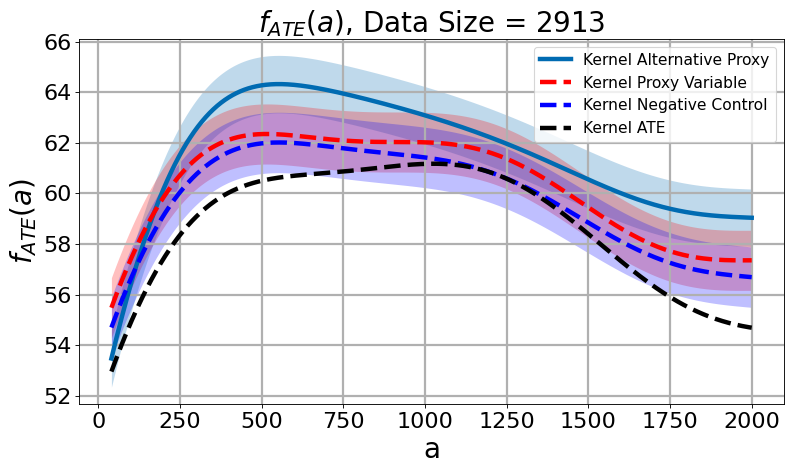

In [11]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting1.2.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 2.1 (Incomplete Z)

In [12]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting2.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[48.488515649422425], [48.61720280249865], [4...","[0.7722033267458401, 0.7719166335185909, 0.771..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[57.49488527942574], [57.54955512782385], [57...","[1.807230278012247, 1.7994745522164788, 1.7917..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[58.60659914687121], [58.658830849302646], [5...","[1.5286744247409585, 1.5195607317583144, 1.510..."


In [13]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,3.4987924,1.1644803
1,Kernel Negative Control,6.821979,1.6301545
2,Kernel Proxy Variable,10.50166,3.6954331


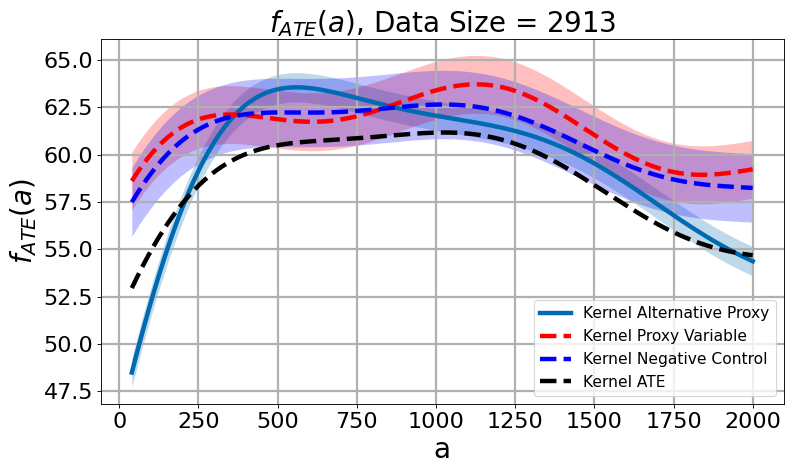

In [14]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting2.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 2.2 (Incomplete W)

In [15]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting2.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[50.65858180206946], [50.77450970131105], [50...","[1.2328460160905315, 1.2289729525899626, 1.225..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[54.355720473162606], [54.42186563865685], [5...","[1.3124641023323744, 1.310313940687731, 1.3081..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[55.58022358331476], [55.64434888787447], [55...","[1.045928484713212, 1.0455212148764796, 1.0452..."


In [16]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,4.7450566,0.777731
1,Kernel Negative Control,2.9878929,2.3176434
2,Kernel Proxy Variable,5.745863,4.519076


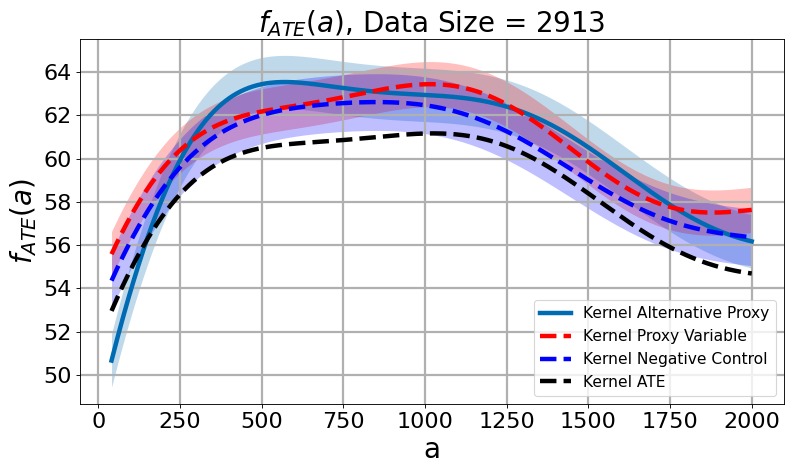

In [17]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting2.2.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 3.1 (Incomplete Z)

In [18]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting3.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[49.06928503937566], [49.18910630541418], [49...","[0.6980283898561102, 0.6981254979818174, 0.698..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[56.6942332086011], [56.757597364468154], [56...","[1.6717919540103703, 1.6643917694769896, 1.657..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[57.9382244008641], [58.0036682090805], [58.0...","[2.00863663562419, 2.0032264188852933, 1.99801..."


In [19]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,2.082232,0.8478151
1,Kernel Negative Control,4.602424,2.3917243
2,Kernel Proxy Variable,9.049987,6.015283


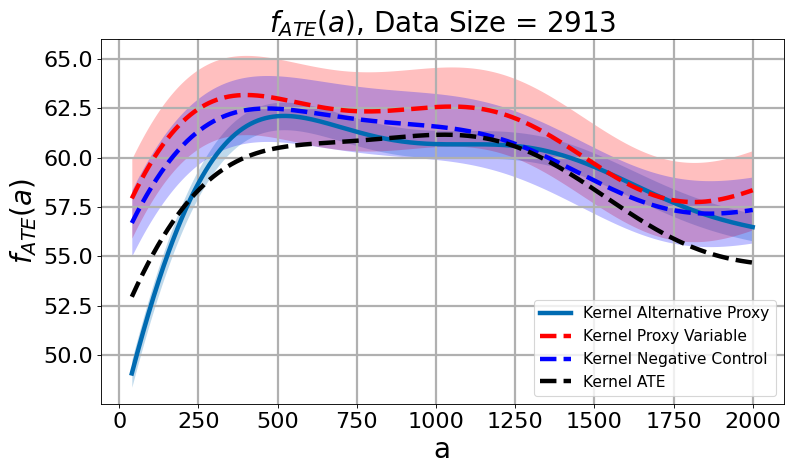

In [20]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting3.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 3.2 (Incomplete W)

In [21]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting3.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[52.09942231504973], [52.201334240340785], [5...","[1.2898850167240152, 1.2844768139207028, 1.279..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[54.64291993662532], [54.70737402887782], [54...","[1.777802702038719, 1.7669326057210093, 1.7561..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[55.778921473149445], [55.84471274441525], [5...","[1.9163429401024294, 1.8999142683925205, 1.883..."


In [22]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,2.5928142,1.5025569
1,Kernel Negative Control,2.8746884,1.0478747
2,Kernel Proxy Variable,5.969052,2.9940093


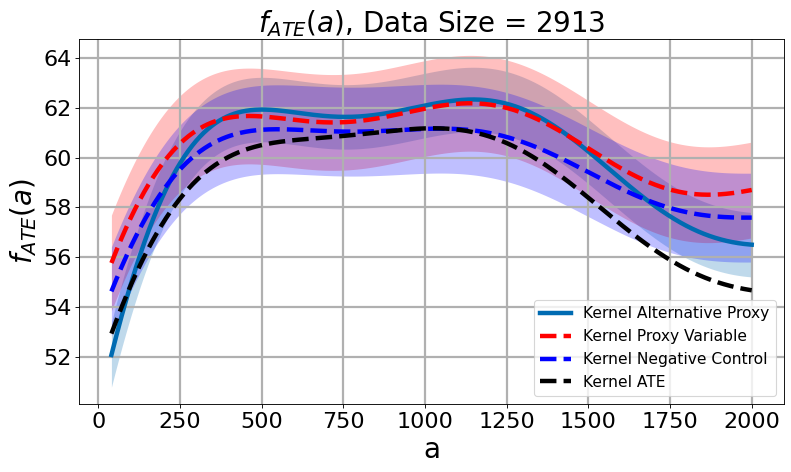

In [23]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting3.2.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 4.1 (Noisy Z)

In [24]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting4.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[50.00519926647313], [50.12367208486823], [50...","[0.7898639038145449, 0.7861558750226999, 0.782..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[56.05379517863099], [56.128536372242095], [5...","[0.6279220293577156, 0.6229616576540223, 0.618..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[63.355752392323176], [63.408927557857815], [...","[2.6593914404741015, 2.6401097537652003, 2.621..."


In [25]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,3.964098,1.0659618
1,Kernel Negative Control,8.839646,4.042652
2,Kernel Proxy Variable,64.57189,18.669691


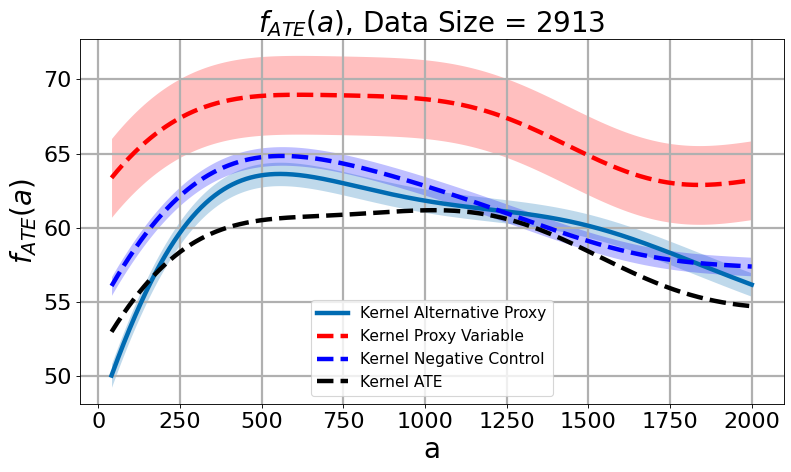

In [26]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting4.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 4.2 (Noisy W)

In [27]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting4.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[54.74449655444248], [54.85181955340251], [54...","[1.0303663616843075, 1.0259147184334767, 1.021..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[52.19165203561082], [52.26820434852798], [52...","[1.3955681639182471, 1.3934509496096559, 1.391..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[55.191487490437204], [55.2634007150934], [55...","[1.6068731238201996, 1.5975788782249023, 1.588..."


In [28]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,12.216348,3.0512836
1,Kernel Negative Control,2.6756952,0.7031358
2,Kernel Proxy Variable,8.038121,4.8539762


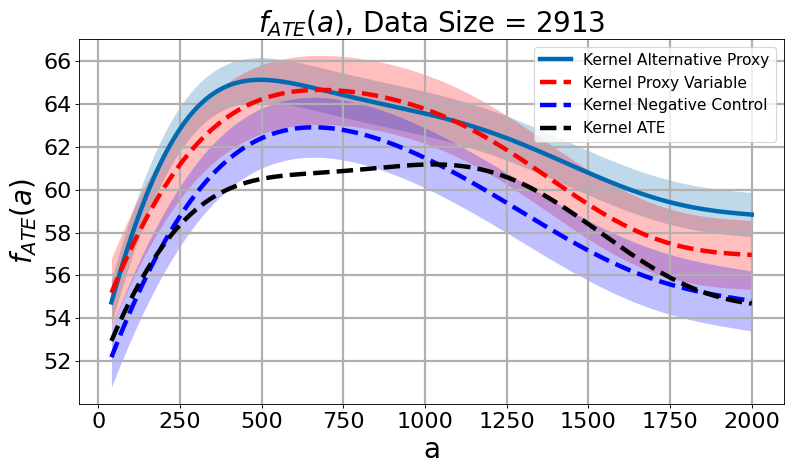

In [29]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting4.2.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 5.1 (Noisy Z)

In [30]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting5.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[50.05352445721244], [50.167526149922296], [5...","[1.572976415125877, 1.570687496144301, 1.56834..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[55.50462875680171], [55.57819926430208], [55...","[2.7755636685068383, 2.763380211108236, 2.7511..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[58.48123552839443], [58.54980999737317], [58...","[3.6930764840807515, 3.6719010569701016, 3.650..."


In [31]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,2.5082948,1.1561786
1,Kernel Negative Control,8.928675,2.9670396
2,Kernel Proxy Variable,24.583029,9.092763


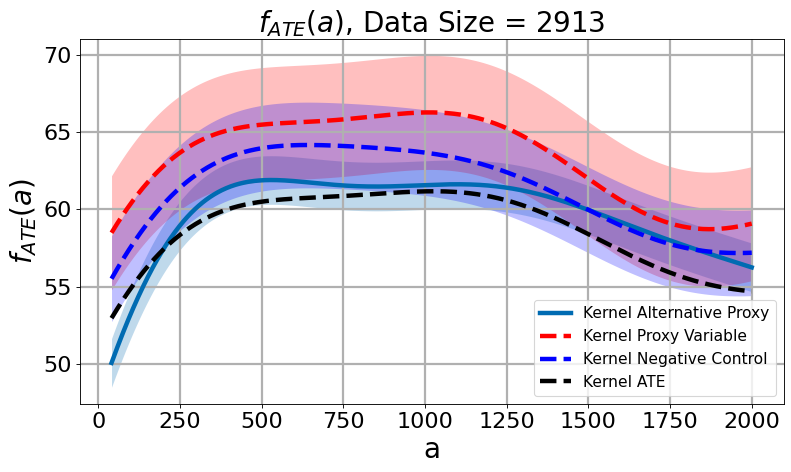

In [32]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting5.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 5.2 (Noisy W)

In [33]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting5.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[51.10888078317161], [51.22018323672965], [51...","[1.9844112435360193, 1.981235792701209, 1.9780..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[53.00459574705737], [53.07797974803147], [53...","[1.689647555926787, 1.679870414914328, 1.67008..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[56.47558579401757], [56.53888265447786], [56...","[2.635166678759722, 2.6167297257374194, 2.5982..."


In [34]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,5.3030057,2.1001713
1,Kernel Negative Control,1.8471352,1.0171372
2,Kernel Proxy Variable,9.578586,4.498468


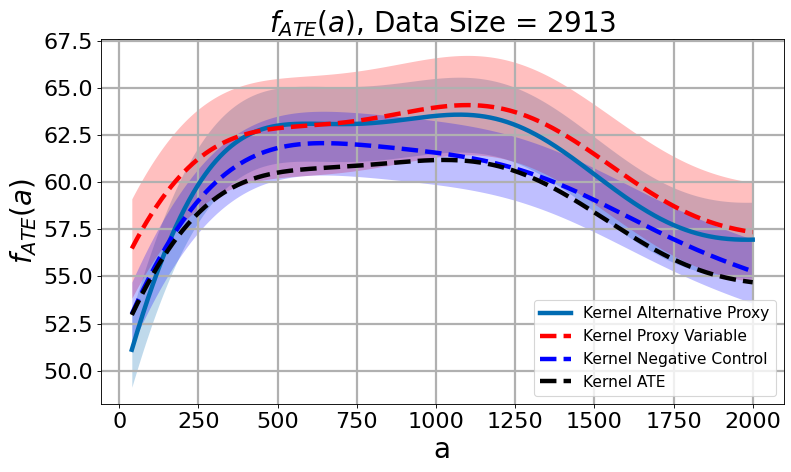

In [35]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting5.2.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 6.1 (Noisy Z)

In [36]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting6.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[49.86683958497641], [49.98863927879468], [50...","[0.9435839052545039, 0.937125712931669, 0.9306..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[56.32748721917227], [56.39552452306996], [56...","[2.965691683881977, 2.9519439910494865, 2.9381..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[58.604665575238144], [58.661311858979595], [...","[4.010698547659455, 3.9860514624896224, 3.9614..."


In [37]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,3.7343488,1.1060758
1,Kernel Negative Control,11.09385,4.8453145
2,Kernel Proxy Variable,25.62212,11.440926


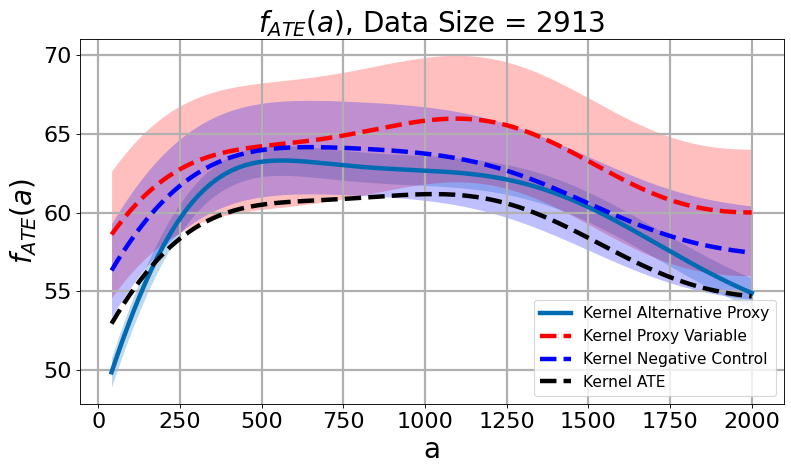

In [38]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting6.1.pdf', format='pdf')
    plt.show()

# JobCorps Dataset Comparsion - Misspecified Setting 6.2 (Noisy W)

In [39]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return x.reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/JobCorps_ATE_Estimation_Comparison_Misspecified_Setting6.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
df_result_kernel_att = df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]
df_results = df_results.loc[df_results["Algorithm"] != "Kernel_ATT"]
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable']
(15, 8)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_Alternative_Proxy,2913,0.0,0.0,"[[52.35719131962744], [52.46973331919448], [52...","[2.2000971554451554, 2.1966485014005177, 2.193..."
1,Kernel_Negative_Control,2913,-1.0,-1.0,"[[53.17218725577338], [53.24735925206606], [53...","[1.6276696627883307, 1.62091401536123, 1.61414..."
2,Kernel_Proxy_Variable,2913,-1.0,-1.0,"[[55.904411688251], [55.9676008069488], [56.03...","[2.0919713549812426, 2.07937925992058, 2.06678..."


In [40]:
gt_ate = df_result_kernel_att['ATE_Estimation'].values[0]

kap_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Alternative_Proxy") & (df_results['sigma_square'] == 0.) & (df_results['lambda_opt_noise'] == 0.), "ATE_Estimation"].values, 1)

knc_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Negative_Control"), "ATE_Estimation"].values, 1)

kpv_ate_estimation = np.concatenate(df_results.loc[(df_results['Algorithm'] == "Kernel_Proxy_Variable"), "ATE_Estimation"].values, 1)

kap_mses = ((kap_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
knc_mses = ((knc_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)
kpv_mses = ((kpv_ate_estimation - gt_ate.reshape(-1, 1)) ** 2).mean(0)

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )
df_mse

,Algorithm,MSE,Std
0,Kernel Alternative Proxy,5.8046775,1.3956504
1,Kernel Negative Control,5.203106,3.6501012
2,Kernel Proxy Variable,15.626602,10.336496


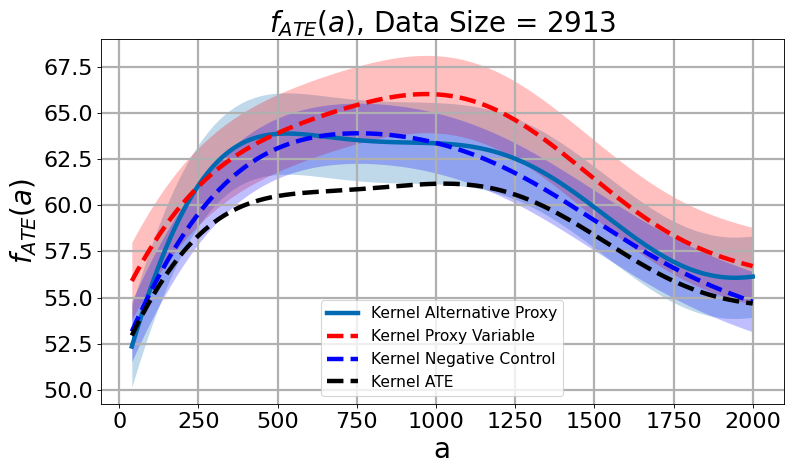

In [41]:
counter = 0
do_A_range = (40, 2000)
do_A = np.linspace(40, 2000, 1000)[:, np.newaxis].reshape(-1)
do_A_size = do_A.shape[0]
sigma_square_ = 0.
lambda_opt_noise = 0.0

for data_size in df_results_aggregated['Data_Size'].unique():
    counter += 1
    
    df_results_data_size = df_results_aggregated.loc[df_results_aggregated['Data_Size'] == data_size]
    
    kernel_alternative_proxy_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_) & (df_results_data_size['lambda_opt_noise'] == lambda_opt_noise)]['ATE_mean'].values[0]
    kernel_alternative_proxy_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Alternative_Proxy') & (df_results_data_size['sigma_square'] == sigma_square_)]['ATE_std'].values[0]
    
    kernel_proxy_variable_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_mean'].values[0]
    kernel_proxy_variable_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Proxy_Variable')]['ATE_std'].values[0]

    kernel_negative_control_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_mean'].values[0]
    kernel_negative_control_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_Negative_Control')]['ATE_std'].values[0]
    
    try:
        kernel_ATT_estimate = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_mean'].values[0]
        kernel_ATT_std = df_results_data_size.loc[(df_results_data_size['Algorithm'] == 'Kernel_ATT')]['ATE_std'].values[0]
    except:
        kernel_ATT_estimate = df_result_kernel_att["ATE_Estimation"].values[0]
        kernel_ATT_std = np.zeros((kernel_ATT_estimate.shape[0]))
    SetPlotRC()
    x = do_A
    fh2=plt.figure(figsize=(10, 6), dpi=80)
    plt.plot(x, kernel_alternative_proxy_estimate, linewidth=4, color='#006BB2', label = 'Kernel Alternative Proxy')
    plt.fill_between(x, (kernel_alternative_proxy_estimate + kernel_alternative_proxy_std)[:,0], (kernel_alternative_proxy_estimate - kernel_alternative_proxy_std)[:,0], alpha=0.25, linewidth=0, color='#006BB2')
    plt.plot(x, kernel_proxy_variable_estimate, linewidth=4, color='r', linestyle = '--', label = 'Kernel Proxy Variable')
    plt.fill_between(x, (kernel_proxy_variable_estimate + kernel_proxy_variable_std)[:,0], (kernel_proxy_variable_estimate - kernel_proxy_variable_std)[:,0], alpha=0.25, linewidth=0, color='r')
    plt.plot(x, kernel_negative_control_estimate, linewidth=4, color='blue', linestyle = '--', label = 'Kernel Negative Control')
    plt.fill_between(x, (kernel_negative_control_estimate + kernel_negative_control_std)[:,0], (kernel_negative_control_estimate - kernel_negative_control_std)[:,0], alpha=0.25, linewidth=0, color='blue')
    
    plt.plot(x, kernel_ATT_estimate, linewidth=4, color='k', linestyle = '--', label = 'Kernel ATE')
    plt.fill_between(x, (kernel_ATT_estimate + kernel_ATT_std)[:,0], (kernel_ATT_estimate - kernel_ATT_std)[:,0], alpha=0.25, linewidth=0, color='k')
    plt.grid(linewidth=2.0)
    plt.legend(fontsize = 14)
    plt.xlabel("a")
    plt.ylabel(r"$f_{{ATE}}(a)$")
    plt.title(r"$f_{{ATE}}(a)$, Data Size = {}".format(data_size))
    ApplyFont(plt.gca(), xlabel_text_size = 25.0, ylabel_text_size = 25.0, title_text_size = 25.0, ticks_text_size = 20,)
    plt.tight_layout()
    plt.savefig('AblationFigures/JobCorps_Proxy_Algos_Comparison_Misspecified_Setting6.2.pdf', format='pdf')
    plt.show()

# Synthetic Low Dimensional Experiments

# Misspecified Setting 1.1

In [42]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting1.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[1.1233109], [1.0372211], [0.9317972], [0.809...","[0.03429947, 0.04233046, 0.049805608, 0.056318..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[1.0344643119803998], [0.9942183690278812], [...","[0.3367483300847266, 0.21420952431530804, 0.11..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[1.4217180012916384], [1.2335719429959586], [...","[0.26857152351514013, 0.1876601844480258, 0.16..."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[0.9068009540621553], [0.8542307399511724], [...","[0.023927746257587142, 0.03152122003946306, 0...."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[1.0097858274368332], [0.9500594870154636], [...","[0.03593465483845297, 0.04554715855594634, 0.0..."


In [43]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.000268,0.000196
1,Kernel Alternative Proxy,0.005536,0.000694
2,Kernel Negative Control,0.297528,0.085453
3,Kernel Proxy Variable,0.041841,0.026613


# Misspecified Setting 1.2

In [44]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting1.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[1.0863088], [1.0879557], [1.0884676], [1.087...","[0.010657637, 0.009848642, 0.0093901325, 0.009..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[0.7217552563490132], [0.7779820484419109], [...","[0.1267868559836341, 0.10623881699437396, 0.08..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[0.9768625110894325], [0.9971927889441549], [...","[0.032976365935632565, 0.03327500292572653, 0...."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[0.7400871504907961], [0.7816036805819301], [...","[0.1265713433758283, 0.10790420561939174, 0.08..."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[0.905362689480142], [0.9250411201476332], [0...","[0.03813145821922464, 0.03812890907798985, 0.0..."


In [45]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.000189,0.000214
1,Kernel Alternative Proxy,0.009327,0.005292
2,Kernel Negative Control,0.010869,0.003737
3,Kernel Proxy Variable,0.005416,0.002178


# Misspecified Setting 2.1

In [46]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting2.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[1.3149989], [1.2142473], [1.0957434], [0.961...","[0.045773298, 0.04927055, 0.05231465, 0.054721..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[1.4842570049827621], [1.3397812153707107], [...","[0.31091163335024913, 0.20745215707969722, 0.1..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[1.179553463582732], [1.1841626458497887], [1...","[0.5682444297455226, 0.3440045065263174, 0.175..."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[1.1902479832579291], [1.110318249961562], [1...","[0.06082478170098257, 0.05471748938770952, 0.0..."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[1.2943854563450437], [1.207042655734516], [1...","[0.08447470378649583, 0.0711941183034398, 0.06..."


In [47]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.000149,0.000092
1,Kernel Alternative Proxy,0.003477,0.001045
2,Kernel Negative Control,0.255051,0.092389
3,Kernel Proxy Variable,0.051221,0.046101


# Misspecified Setting 2.2

In [48]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting2.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[1.2867314], [1.290852], [1.293453], [1.29466...","[0.007088982, 0.004490984, 0.0025414259, 0.002..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[0.8912869436590096], [0.9391198824624791], [...","[0.10263401567071118, 0.09226646367034681, 0.0..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[1.1504978636590912], [1.1702038033276128], [...","[0.07291577936777596, 0.06967903926288206, 0.0..."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[0.8790487659885551], [0.9211699363958037], [...","[0.0813207352143533, 0.07396283241449586, 0.06..."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[1.0733250275065633], [1.0936629833023794], [...","[0.030527254067677794, 0.03094844119559595, 0...."


In [49]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.000043,0.000034
1,Kernel Alternative Proxy,0.015323,0.005482
2,Kernel Negative Control,0.013338,0.004377
3,Kernel Proxy Variable,0.008997,0.004912


# Misspecified Setting 3.1

In [50]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting3.1.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[2.672904], [2.6430955], [2.6078694], [2.5678...","[0.13174985, 0.11778964, 0.10430563, 0.0914437..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[3.0458518256257614], [2.9724178337535263], [...","[0.4779990271566845, 0.36756272330061307, 0.27..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[3.7282079756170723], [3.56976428216839], [3....","[0.2778766393071035, 0.2664196068771292, 0.256..."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[2.9598528645714333], [2.8849782181083055], [...","[0.32826581693341267, 0.27275920246107715, 0.2..."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[2.9371257845772205], [2.88040307197807], [2....","[0.24250278966377492, 0.22473996241546812, 0.2..."


In [51]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.011054,0.007013
1,Kernel Alternative Proxy,0.011290,0.008237
2,Kernel Negative Control,0.033125,0.024247
3,Kernel Proxy Variable,0.019820,0.008853


# Misspecified Setting 3.2

In [52]:
def popstd(x):
    return np.concatenate(x.values, axis = 1).std(1)

def reshape_1_1(x):
    return np.array(x).reshape(-1, 1)
    
df_results = pd.read_pickle(r"../Results/SyntheticLowDim_ATE_Comparison_Misspecified_Setting3.2.pkl")
df_results.loc[df_results['sigma_square'].isnull(), 'sigma_square'] = -1.
df_results.loc[df_results['lambda_opt_noise'].isnull(), 'lambda_opt_noise'] = -1.
df_results.loc[df_results['alternative_proxy_eta_parameter'].isnull(), 'alternative_proxy_eta_parameter'] = -1.
df_results["ATE_Estimation"] = df_results["ATE_Estimation"].apply(reshape_1_1)
    
pd.concat([df_results, df_results.loc[df_results["Algorithm"] == "Kernel_ATT"]], ignore_index = True)

df_results_aggregated = df_results.groupby(['Algorithm', 'Data_Size', 'sigma_square', 'lambda_opt_noise']).agg({ 'ATE_Estimation':['mean', popstd]}).set_axis(['ATE_mean', 'ATE_std'], axis=1).reset_index()

print(df_results["Algorithm"].unique())
print(df_results.shape)

df_results_aggregated.head()

['Kernel_Alternative_Proxy' 'Kernel_Negative_Control'
 'Kernel_Proxy_Variable' 'Kernel_ATE']
(35, 9)


,Algorithm,Data_Size,sigma_square,lambda_opt_noise,ATE_mean,ATE_std
0,Kernel_ATE,1000,-1.0,-1.000,"[[2.3312097], [2.4248497], [2.5164256], [2.605...","[0.1560826, 0.15686782, 0.15640078, 0.15437098..."
1,Kernel_Alternative_Proxy,1000,0.0,0.000,"[[1.6234060990204988], [1.716074123584002], [1...","[0.08376279121680749, 0.09139148396837761, 0.1..."
2,Kernel_Alternative_Proxy,1000,0.0,0.004,"[[2.321915389136864], [2.4834904692093884], [2...","[0.33583399823371335, 0.3295507747152342, 0.31..."
3,Kernel_Alternative_Proxy,1000,1.0,0.000,"[[1.606484680126646], [1.6889328574033855], [1...","[0.07543665522978897, 0.08351966655701236, 0.1..."
4,Kernel_Alternative_Proxy,1000,1.0,0.004,"[[2.088708976385663], [2.212358377170119], [2....","[0.2763209413256646, 0.2903796825072804, 0.300..."


In [53]:
df_results_ = df_results.loc[((df_results['sigma_square'] == 1.) | (df_results['sigma_square'] == -1.)) & ((df_results['lambda_opt_noise'] == 0.) | (df_results['lambda_opt_noise'] == -1.))]

df_mse = pd.DataFrame(columns = ["Algorithm", "MSE", "Std"])

kate_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_ATE']['Causal_MSE']
kap_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Alternative_Proxy']['Causal_MSE']
knc_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Negative_Control']['Causal_MSE']#.values()
kpv_mses = df_results_.loc[df_results_['Algorithm'] == 'Kernel_Proxy_Variable']['Causal_MSE']#.values()

df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel_ATE", "MSE" : kate_mses.mean(), "Std" : kate_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Alternative Proxy", "MSE" : kap_mses.mean(), "Std" : kap_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Negative Control", "MSE" : knc_mses.mean(), "Std" : knc_mses.std() }])], ignore_index=True )
df_mse = pd.concat([df_mse, pd.DataFrame([{"Algorithm" : "Kernel Proxy Variable", "MSE" : kpv_mses.mean(), "Std" : kpv_mses.std() }])], ignore_index=True )

df_mse

,Algorithm,MSE,Std
0,Kernel_ATE,0.003303,0.002622
1,Kernel Alternative Proxy,0.184369,0.048890
2,Kernel Negative Control,0.095688,0.025107
3,Kernel Proxy Variable,0.053943,0.015169
